In [29]:
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display

def getFunction(x):
    a = x[0]
    b = x[1]
    r = np.sin(a**2 - b**2) + np.cos(a**2 + b**2)
    return r

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def getGradient(x):
    a = x[0]
    b = x[1]
    r0 = 2*a*(np.cos(a**2 - b**2) - np.sin(a**2 + b**2))
    r1 = -2*b*(np.cos(a**2 - b**2) + np.sin(a**2 + b**2))
    r = np.array([[r0], 
                 [r1]])
    return r

def getHessian(x):
    a = x[0]
    b = x[1]
    r0 = -2*(2*a**2*np.sin(a**2 - b**2) + np.sin(a**2 + b**2) + 2*a**2*np.cos(a**2 + b**2) - np.cos(a**2 - b**2))
    r1 = 4*a*b*(np.sin(a**2 - b**2) - np.cos(a**2 + b**2))
    r2 = 4*a*b*(np.sin(a**2 - b**2) - np.cos(a**2 + b**2))
    r3 = -2*(2*b**2*np.sin(a**2 - b**2) + np.sin(a**2 + b**2) + 2*b**2*np.cos(a**2 + b**2) + np.cos(a**2 - b**2))
    r = np.array([[r0, r1], [r2, r3]])
    return r

def armijo(x, d):
    y = 0.8
    n = 0.25
    t = 1
    
    gradient = getGradient(x)
    while getFunction([x[0] + t*d[0,0], x[1] + t*d[1,0]]) > getFunction(x) + n * t * (gradient.transpose().dot(d)):
        t = y*t
    
    return t

def auxAurea(x, d, t):
    return getFunction([x[0] + t*d[0,0], x[1] + t*d[1,0]])
    
def aurea(x, d):
    e = 0.01
    p = 0.25
    teta1 = (3 - 5**(1/2))/2
    teta2 = 1 - teta1
    
    # Obtendo Intervalo [a,b]
    a = 0
    s = p
    b = 2*p
    while auxAurea(x, d, b) < auxAurea(x, d, s):
        a = s
        s = b
        b = 2*b
        
    # Obtendo t em [a,b]
    u = a + teta1 * (b - a)
    v = a + teta2 * (b - a)
    while (b - a) > e:
        if auxAurea(x, d, u) < auxAurea(x, d, v):
            b = v
            v = u
            u = a + teta1 * (b - a)
        else:
            a = u
            u = v
            v = a + teta2 * (b - a)
    
    return (u + v)/2

def inverseMatrix(x):
    a,b,c,d = x
    det = a * d - b * c
    x[0] = d/det
    x[1] = -1*b/det
    x[2] = -1*c/det
    x[3] = a/det
    return

def minGradient(xi, search):
    it = 0
    x = xi
    grad = getGradient(x)
    while (it < 1000):
        if np.count_nonzero(grad) != 0:
            d = np.array([[-1 * grad[0,0]], [-1 * grad[1,0]]])
            t = search(x, d)
            x = [x[0] + t*d[0,0], x[1] + t*d[1,0]]
            it = it+1
            grad = getGradient(x)
        else:
            break
    
    return x, it

def minNewton(xi, search):
    it = 0
    x = xi
    d = [0,0]
    grad = getGradient(x)
    diff = np.array([[10**10], 
                 [10**10]])
    while (it < 1000):
        if np.count_nonzero(grad) != 0:
            hess = getHessian(x)
            if (is_pos_def(hess)):
                invhess = np.linalg.inv(hess) 
                grad = getGradient(x)
                d = -1*invhess.dot(grad)
                t = search(x, d)
                x = [x[0] + t*d[0,0], x[1] + t*d[1,0]]
                it = it+1
            else:
                if (it == 0):
                    print(xi, 'initial hess not pos def')
                break
        else:
            break
    
    return x, it

def minQuasiNewton(xi, search):
    it = 0
    x = xi
    d = [0,0]
    h = np.array([[1,0],[0,1]])
    grad = getGradient(x)
    defpostest = 10**10
    q = np.array([[10**10], 
                 [10**10]])
    while (it < 1000):
        if np.count_nonzero(grad) != 0:
            if (is_pos_def(h)):
                grad = getGradient(x)
                d = -1*h.dot(grad)
                t = search(x, d)
                x0 = x
                x = [x[0] + t*d[0,0], x[1] + t*d[1,0]]
                p = np.array([[x[0] - x0[0], x[1] - x0[1]]]).transpose()
                gradx = getGradient(x)
                gradx0 = getGradient(x0)
                q = gradx0 - gradx
                part1 = q.transpose().dot(h).dot(q)[0,0] / p.transpose().dot(q)[0,0]
                part2 = p.dot(p.transpose()) / p.transpose().dot(q)[0,0]
                part3 = p.dot(q.transpose()).dot(h)
                h = h + ((1 + part1)* part2) - part3
                it = it+1
            else:
                break
        else:
            break
    
    return x, it

def getResults(x, minimize, search):
    r, i = minimize(x, search)
    m = getFunction(r)
    return [x, i, 0, r, m, 0]
        

        
        
xo_list = [[2.219931710897395, 8.707323061773764], [8.928601514360016, 3.3197980530117723], [0.7630828937395717, 7.7991879224011464], [8.734294027918162, 9.68540662820932], [0.10374153885699955, 5.018745921487388]]
minimization_methods = [minGradient, minNewton, minQuasiNewton]
minimization_names = ["gradiente", "newton", "quase newton"]
search_methods = [armijo, aurea]
search_names = ["armijo", "aurea"]

for method in minimization_methods:
    for search in search_methods:
        data = [["X0", "Iter.", "Search Iter.", "X Opt.", "Opt. Value", "Error"]]
        for xo in xo_list:
            data.append(getResults(xo, method, search))
            
        print("Usando o método de minimização %s with the search method %s" %(minimization_names[minimization_methods.index(method)], search_names[search_methods.index(search)]))
        display(HTML('<table><tr>{}</tr></table>'.format(
           '</tr><tr>'.join(
               '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )))
            
        
# data = [["X0", "Iter.", "Search Iter.", "X Opt.", "Opt. Value", "Error"],
#          ["Sun",696000,1989100000],
#          ["Earth",6371,5973.6],
#          ["Moon",1737,73.5],
#          ["Mars",3390,641.85]]


# display(HTML('<table><tr>{}</tr></table>'.format(
#        '</tr><tr>'.join(
#            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
#        )))


SyntaxError: invalid syntax (<ipython-input-29-47f02586e1a2>, line 122)

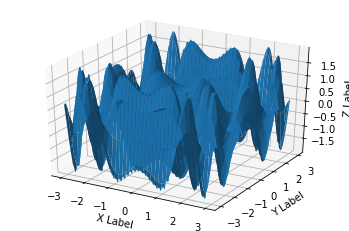

In [2]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(-3.0, 3.0, 0.05)
X, Y = np.meshgrid(x, y)
zs = np.array(getFunction([np.ravel(X), np.ravel(Y)]))
Z = zs.reshape(X.shape)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()